# Tarea 2 - Procesamiento distribuido y redes neuronales profundas
**Integrantes:** 

Camila Goméz Nazal -
Ignacio Zurita Tapia

In [1]:
import torch
import numpy as np
from torchvision.datasets import DatasetFolder
import torchvision.models as models
from torchvision.transforms import Compose, RandomHorizontalFlip, Resize, RandomRotation, Lambda, ToTensor, CenterCrop, Normalize
from torch.utils.data import DataLoader, Sampler, RandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from IPython.display import HTML
from PIL import Image
from torchvision import get_image_backend
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from skimage.io import imshow
from sklearn.linear_model import LogisticRegression 
from keras.applications.imagenet_utils import decode_predictions
seed = 81818 
torch.random.manual_seed(seed)

## Carga y transformación de datos


#### 1. Dataset Folder

In [2]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
            
def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def loader(path):
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [3]:
scale = Lambda(lambda x: torch.div(x, torch.max(x)))
brightness = Lambda(lambda x: torch.mul(x, torch.FloatTensor(x.shape[0], x.shape[1], x.shape[2]).uniform_(1.2, 1.5)))

In [4]:
root = 'ChestXRay2017/chest_xray'
extensions = ('.jpeg')
transform = Compose([Resize([224,224]),
                     RandomHorizontalFlip(0.5),
                     RandomRotation([-20,20]),
                     ToTensor(),
                     brightness,
                     scale
                    ])

train = DatasetFolder(root + '/train', loader, extensions, transform)
test = DatasetFolder(root + '/test', loader, extensions, transform)

#### 2. Cantidad de muestras en cada clase en train y test:



In [5]:
HTML(filename='distribucion_datos.html')

,Normal,Neumonía
Train,1349,3884
Test,234,390


#### 3.

In [6]:
etiquetas_prueba = list(zip(*test.samples))[1]
l1=len(test.samples)
ind_test = np.random.choice(l1, l1 )
ind_test.shape

(624,)

In [7]:
l =len(train.samples)
np.random.seed(0)
indices = np.random.choice(l, l, replace=False)
indices.shape

(5232,)

In [8]:
ind_train = indices[:int(0.8*l)]
ind_val   = indices[int(0.8*l):]
print(ind_train.shape)
print(ind_val.shape)

(4185,)
(1047,)


In [9]:
val_samples = [train.samples[i] for i in ind_val]
etiquetas_val  = list(zip(*val_samples))[1]
print(etiquetas_val.count(0))
print(etiquetas_val.count(1))

263
784


In [10]:
class ReplicarMuestreoDePrueba(Sampler):
    def __init__(self, etiquetas_prueba, indices_val, etiquetas_val):
        self.etiquetas_prueba = etiquetas_prueba
        self.indices_val      = indices_val
        self.etiquetas_val    = etiquetas_val
    def __iter__(self):
        dist_test   = self.etiquetas_prueba.count(0)/self.etiquetas_prueba.count(1)
        dist_val    = int(self.etiquetas_val.count(1)*dist_test)
        nro_etiq_nuevas = dist_val - self.etiquetas_val.count(0) 
        c=0
        for i in range(len(etiquetas_val)):
            if etiquetas_val[i]==0:
                self.indices_val.append(self.indices_val[i])
                c+=1
            if c==nro_etiq_nuevas:
                break
        return iter(self.indices_val)

c = ReplicarMuestreoDePrueba(etiquetas_prueba,list(ind_val),etiquetas_val)
it = c.__iter__()

#### 4.

In [11]:
train_sampler = SubsetRandomSampler(ind_train)
valid_sampler = SubsetRandomSampler(list(it))
test_sampler = RandomSampler(ind_test)

batch_size = 16
train_loader = torch.utils.data.DataLoader(train, batch_size= batch_size, 
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train, batch_size= batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, 
                                           sampler=test_sampler)

print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

4185
1254
624


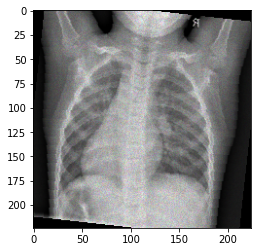

In [12]:
plt.imshow(train[0][0].permute(1, 2, 0).numpy())

## Redes convolucionales profundas

1.

In [13]:
import torch.nn as nn
class DWSepConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=True):
        super(DWSepConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=1,
                                   padding=padding, bias=bias, groups = in_channels)
        self.pointwise = nn.Conv2d(in_channels , out_channels, kernel_size=1)
    def forward(self,x):
        D = self.depthwise(x)
        P = self.pointwise(D)
        return P
        

2.

In [14]:
class VGG16DWSep(nn.Module):
    def __init__(self):
        super(VGG16DWSep, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            DWSepConv2d(64,128,kernel_size=3, padding=1),
            nn.ReLU(),
            DWSepConv2d(128,128,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            DWSepConv2d(128,256,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            DWSepConv2d(256,256,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            DWSepConv2d(256,256,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            DWSepConv2d(256,512,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            DWSepConv2d(512,512,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(100352, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.7),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,2))
        
    def forward(self,x):
        return self.layers(x)
         

3.

In [15]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
model = VGG16DWSep()

In [16]:
model.layers[0].weight.data = vgg16.features[0].weight.data
model.layers[0].bias.data = vgg16.features[0].bias.data
model.layers[2].weight.data = vgg16.features[2].weight.data
model.layers[2].bias.data = vgg16.features[2].bias.data

4.

In [17]:
class EarlyStopping():
    def __init__(self, modo='min', paciencia=5, porcentaje=False, tol=0):
        assert(modo == 'min' or modo == 'max')
        
        self.modo = modo
        self.paciencia = paciencia
        self.porcentaje = porcentaje
        self.tol = tol
        self.best_metrica = float('inf') if modo == 'min' else -float('inf')
        self.count = 0
        
    def mejor(self, metrica_validacion):
        
        if(self.porcentaje):
            delta = metrica_validacion/self.best_metrica
            if (self.modo == 'min'):
                return delta < 1 + self.tol 
            else:
                return delta > 1 + self.tol
        else:
            delta = metrica_validacion - self.best_metrica
            if (self.modo == 'min'):
                return delta + self.tol < 0
            else:
                return delta - self.tol > 0
            
    def deberia_parar(self, metrica_validacion):
        if(self.mejor(metrica_validacion)):
            self.count = 0
            self.best_metrica = metrica_validacion
        else:
            self.count+=1
            
        return self.count > self.paciencia

5.

In [32]:

def train_loop(model, 
               train_dataloader, 
               validation_dataloader, 
               test_dataloader, 
               optimizer,
               criterion,
               n_epochs=1):
    
    running_loss = 0
    early_stopping = EarlyStopping()
    
    for epoch in range(n_epochs):
        for j, (X_train, y_train) in enumerate(train_dataloader):
            
            optimizer.zero_grad()
            y_pred = model.forward(X_train)
            y_pred = nn.Softmax(dim=1).forward(y_pred)
            
            loss = criterion(y_pred,y_train)
            loss.backward()
            optimizer.step()
            
                
            running_loss += loss.item()
        
        validation_loss = 0
        for i, (X_val, y_val) in enumerate(validation_dataloader):
            
            y_pred_validation = model.forward()
            y_pred_validation = nn.Softmax(dim=1).forward(y_pred_validation)
            current_val_loss = criterion(y_pred_validation, y_val)
            validation_loss+=current_val_loss
        if(early_stopping.deberia_parar(validation_loss/(i+1))):
            print('Train stopped: Early stopping')
            break

In [35]:
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
n_epochs = 1

train_loop(model, train_loader, valid_loader, test_loader, optimizer, criterion, n_epochs)

[1,     1] loss: 0.000
[1,     2] loss: 0.000
[1,     3] loss: 0.000
[1,     4] loss: 0.000
[1,     5] loss: 0.000
[1,     6] loss: 0.000
[1,     7] loss: 0.000
[1,     8] loss: 0.692
[1,     9] loss: 0.619
[1,    10] loss: 0.514
[1,    11] loss: 0.000
[1,    12] loss: 0.258
[1,    13] loss: 0.000
[1,    14] loss: 0.008
[1,    15] loss: 0.068
[1,    16] loss: 0.081
[1,    17] loss: 0.055
[1,    18] loss: 0.000
[1,    19] loss: 0.000
[1,    20] loss: 0.000
[1,    21] loss: 0.000
[1,    22] loss: 0.000
[1,    23] loss: 0.000
[1,    24] loss: 0.000
[1,    25] loss: 0.287
[1,    26] loss: 0.000
[1,    27] loss: 0.000
[1,    28] loss: 0.000
[1,    29] loss: 0.000
[1,    30] loss: 0.254
[1,    31] loss: 0.000
[1,    32] loss: 0.000
[1,    33] loss: 0.000
[1,    34] loss: 0.117
[1,    35] loss: 0.000
[1,    36] loss: 0.001
[1,    37] loss: 0.000
[1,    38] loss: 0.136
[1,    39] loss: 0.160
[1,    40] loss: 0.000
[1,    41] loss: 0.137
[1,    42] loss: 0.094
[1,    43] loss: 0.025
[1,    44] 

KeyboardInterrupt: 

## Interpretabilidad

1.

In [2]:
transform2 = Compose([Resize([299,299]),
                      CenterCrop(299),
                      ToTensor(),
                      Normalize(mean= [0.485, 0.456, 0.406] , std =[0.229, 0.224, 0.225])
                     ])

2.

In [3]:
inceptV3 = models.inception_v3(pretrained=True)

In [26]:
img= Image.open("C:/Users/camil/tarea2-MA6202/P3_example.jpg").convert('RGB') 
img = transform2(img)
img.shape

torch.Size([3, 299, 299])

In [27]:
inceptV3.eval()
with torch.no_grad():
    pred = inceptV3.forward(img.unsqueeze(0))

pred = decode_predictions(np.asarray(pred),top = 1)
pred[0][0][1]

'Labrador_retriever'

3.

torch.Size([3, 299, 299])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


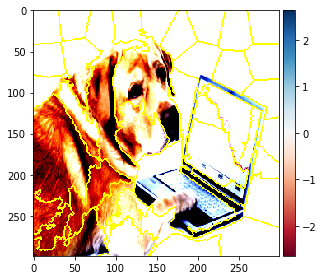

In [28]:
print(img.shape)
img_asnp = np.asarray(torch.rot90(img.T, -1))
img_seg = slic(img_asnp, n_segments=80)
mb = mark_boundaries(img_asnp, img_seg)
imshow(mb)

In [29]:
a = np.unique(img_seg, return_counts=True)[0]
print(a)
len(a)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]


38

4.

In [30]:
perturb = []
for i in range(1000):
    perturb.append(np.random.binomial(1, 0.5, len(a)))
perturb[0].shape

(38,)

5.

In [31]:
imgs_per = []
for i in range(1000):
    pert=perturb[i]
    im = np.copy(img_asnp)
    for i in range(pert.shape[0]):
        if pert[i] == 0:
            mask = img_seg==a[i]
            im[mask] = 0
           
    imgs_per.append(im)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


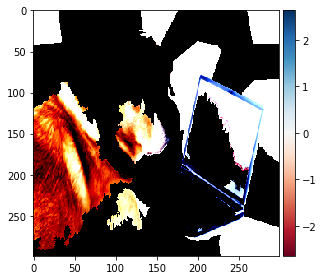

In [32]:
imshow(imgs_per[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


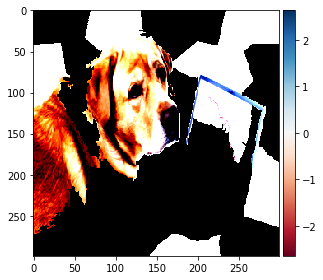

In [33]:
imshow(imgs_per[500])

6.

In [34]:
y=[]
inceptV3.eval()
with torch.no_grad():
    for i in range(1000):
        trans1 = ToTensor()
        img = trans1(imgs_per[i])
        pred1 = inceptV3.forward(img.unsqueeze(0))
        pred1 = decode_predictions(np.asarray(pred1),top = 1)
        if pred1[0][0][1] == pred[0][0][1]:
            y.append(1)
        else:
            y.append(0)

y.count(1)

530

7.

In [35]:
def d(x_p, z_p):
    v = x_p @ z_p
    v1 = np.linalg.norm(x_p) * np.linalg.norm(z_p)
    v2 = v/v1
    return 1 - v2

def pi_x(x_p, z_p, sigma):
    dist = - ( (d(x_p,z_p))**2 )
    val = dist / (sigma**2)
    return np.exp(val)

dist_coseno=[]
for i in range(len(perturb)):
    pi = pi_x(a,perturb[i], 0.2)
    dist_coseno.append(pi)

dist_coseno=np.array(dist_coseno)
dist_coseno.shape

(1000,)

8.

In [36]:
train_Dp = np.array(perturb)
labels = np.array(y)
print(train_Dp.shape)
print(labels.shape)

(1000, 38)
(1000,)


9.

In [37]:
model = LogisticRegression()
model.fit(train_Dp, labels, sample_weight = dist_coseno)

C:\Users\camil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

10.

In [38]:
coefs = model.coef_
coefs = coefs.reshape(len(a),1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


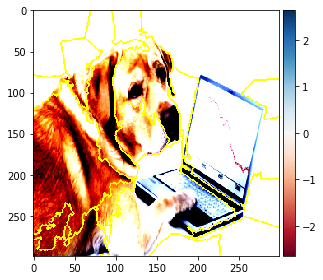

In [39]:
img_seg_importantes = np.copy(img_seg)
for i in range(len(a)):
    if coefs[i]<0:
        mask = img_seg_importantes==a[i]
        img_seg_importantes[mask] = -1
    
mb = mark_boundaries(img_asnp, img_seg_importantes)
imshow(mb)

11.

In [41]:
from skimage.color import rgb2gray

img_gray = rgb2gray(img_asnp)

In [42]:
img_gray.shape

(299, 299)

In [43]:
observaciones = []
for i in range(299):
    for j in range(299):
        arr = np.zeros(3)
        arr[0] = i
        arr[1] = j
        arr[2] = img_gray[i][j]
        observaciones.append(arr)

observaciones = np.asarray(observaciones)
observaciones.shape

(89401, 3)

In [44]:
observaciones

array([[  0.        ,   0.        ,   2.37968183],
       [  0.        ,   1.        ,   2.37968183],
       [  0.        ,   2.        ,   2.37968183],
       ...,
       [298.        , 296.        ,   2.40563703],
       [298.        , 297.        ,   2.40563703],
       [298.        , 298.        ,   2.40563703]])

In [47]:
from sklearn.cluster import KMeans

est = KMeans(n_clusters=len(a))
X = observaciones
clust_list = est.fit_predict(X)



In [48]:
clust_list = clust_list.reshape(299,299)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


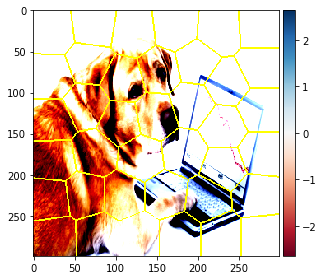

In [49]:
mb = mark_boundaries(img_asnp, clust_list)
imshow(mb)

In [50]:
from sklearn.cluster import AgglomerativeClustering

est = AgglomerativeClustering(n_clusters=40)
clust_list = est.fit_predict(X)


MemoryError: 

In [84]:
clust_list2

array([ -1,  -1,  -1, ..., 331, 331, 331], dtype=int64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


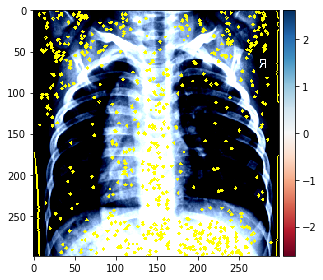

In [85]:
mb = mark_boundaries(img_asnp, clust_list2.reshape(299,299))
imshow(mb)

12.